# Project Machinaal leren

## Brainstorm

#### Ideëen:
- Fake reviews detecteren: bv. bij het opstarten van een restaurant zullen de eigenaars soms reviews over zichzelf posten.

- Populariteitsrating per restaurant, bepaald door hoeveelheid reviews in een bepaalde periode, door wie, en goed/slechte reviews
- If you want to open a restaurant, how would you design your restaurant to be the most profitable? 
Hebben bepaalde tags goedkopere/duurdere price range, welke tags de meeste goede reviews krijgen,... -> Hoeveel restaurants in die stad hebben deze tag al? 
- Welke features vaker een goede review krijgen op welk moment. (bv. outdoor seating krijgt betere reviews in de zomer)
- Betekenis geven aan $ tekens
- Gemiddelde prijs per stad
- Reviews talen detecteren en linken met restaurants (welke restaurants krijgen meest reviews in verschillende talen,...)
- Frequentietabel van reviews -> per restaurant positieve en negatieve punten oplijsten

#### Ideëen met externe data:
- Voor elk restaurant coordinaten bepalen via https://developers.google.com/maps/documentation/geocoding/overview

- Afstand totaan markt/monumenten bepalen en zien of die betere reviews krijgen

#### Predicties:
- Leeftijd van de reviewers bepalen?

- Restaurants aanbevelen aan reviewers

In [73]:
import pandas as pd
import seaborn as sn
import numpy as np
from sklearn import preprocessing
# Read csv
original_listing_df = pd.read_csv("restaurant_listings.csv")
original_reviews_df = pd.read_csv("reviews.csv")

## Data opsplitsen

De data wordt eerst opgedeeld in een training set en een test set. Dit is noodzakelijk zodat we de performantie van het model kunnen testen. Hierbij is de trainingsset 4 keer groter dan de testset.

OPM van Axelle (TODO): Ik weet niet of we dat dan al moeten doen en of we zo moeten werken met die folds

(Gaetan) Ik denk dat dit goed is, die folds hoeven nog niet, lijkt me nog iets te complex voor data cleaning (zie https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)

In [86]:
from sklearn.model_selection import train_test_split
df_train_listing, df_test_listing = train_test_split(original_listing_df, test_size=0.2) 
df_train_reviews, df_test_reviews = train_test_split(original_reviews_df, test_size=0.2) 

## Data opkuisen

Voor we kunnen starten met de data-analyse, moeten we de data opkuisen. In deze sectie voeren we volgende stappen uit:
- Kolommen droppen
- Entries droppen
- Formaat van kolommen aanpassen

### Kolommen droppen

Kolommen die geen meerwaarde bieden voor hetgene dat we willen onderzoeken, worden verwijderd. 

In [87]:
cleaned_listing_df = df_train_listing.drop(columns=["phone number","website url","menu url", "timetable","email address"])
# OPM Axelle: travelers choice en michelin heb ik laten staan voor 
# eventueel verband met een ander attribuut, maar mag weg als we daar 
# niets mee gaan doen (TODO)
# OPM Othello: Ik denk dat we eigenlijk timetable ook kunnen gebruiken voor bvb de openingsuren dat het beste doen. Michelin is een goed idee inderdaad.

Kolommen die voor minstens 85% leeg zijn, worden ook verwijderd. Enkel de kolom "dutch description" wordt verwijderd.
OPM Othello: gingen we de description niet gebruiken om te zoeken naar kernwoorden in de beschrijving die goed deden? 

In [88]:
# Listing restaurants
percent_empty_listing = cleaned_listing_df.isnull().sum() * 100 / len(cleaned_listing_df)
print(round(percent_empty_listing,2))
# Reviews
percent_empty_reviews = df_train_reviews.isnull().sum() * 100 / len(df_train_reviews)
print(round(percent_empty_reviews,2))

cleaned_listing_df.dropna(axis=1,thresh=cleaned_listing_df.shape[0]*0.15, inplace=True)

rank                    8.24
restaurant name         0.00
general rating          0.00
number of reviews       0.00
tags                    7.90
address                 0.00
travelers choice        0.00
michelin                0.00
food rating             0.00
service rating          0.00
value rating            0.00
atmosphere rating       0.00
description            79.84
dutch description      88.37
price range             0.00
cuisines               12.35
special diets          65.70
meals                  23.01
restaurant features    29.80
id                      0.00
dtype: float64
id               0.00
reviewer name    0.00
title            0.01
date             0.00
rating           0.00
review           0.00
dtype: float64


### Entries droppen

TODO: bv zeer weinig aantal reviews => niet relevant?, geen general rating?

Ratings van -1 droppen of invullen?

Eerst en vooral zullen we (zoals gezien in het eerste labo) de meegekregen waarde van de 'general rating' splitsen zodat we enkel de numerieke waarden van het aantal bubbels over houden.

In [89]:
cleaned_listing_df["general rating"] = cleaned_listing_df["general rating"].str.split("of").str[0]
cleaned_listing_df['general rating'] = pd.to_numeric(cleaned_listing_df['general rating'])
print(cleaned_listing_df['general rating'])
percent_empty_listing = (cleaned_listing_df['atmosphere rating']==-1).sum() * 100 / len(cleaned_listing_df)
print(round(percent_empty_listing,2))

787     4.5
2005    3.5
426     4.5
2417   -1.0
2314    2.5
       ... 
925     3.5
2312    3.0
51      4.5
1650    3.0
1110    5.0
Name: general rating, Length: 2064, dtype: float64
80.57


Als we kijken naar een aantal waarden in de kolom, kunnen we zien dat sommige cellen een negatieve waarde hebben. Dit komt alvast doordat deze restaurants nog geen beoordeling hebben gekregen. 

Omdat Tripadvisor werkt met een rank systeem zullen deze restaurants de laagste ranks invullen en wellicht bijna nooit bekeken worden door gebruikers van de site. Hierdoor zullen wij deze waardes niet meerekenen in ons onderzoek.

In [90]:
cleaned_listing_df= cleaned_listing_df[cleaned_listing_df['general rating'] != -1]


We kijken nu nog eens naar onze DataFrame.

In [91]:
display(cleaned_listing_df)

,rank,restaurant name,general rating,number of reviews,tags,address,travelers choice,michelin,food rating,service rating,value rating,atmosphere rating,description,price range,cuisines,special diets,meals,restaurant features,id
787,#7,Bistro Ruyterhof,4.5,13 reviews,$$ - $$$|French|Belgian|European,"Grote Baan 159, Waasmunster 9250 Belgium",False,False,5.0,5.0,5.0,-1.0,NaN,€19 - €38,"French, Belgian, European, Healthy",NaN,"Lunch, Dinner","Reservations, Table Service, Seating, Gift Car...",21149871
2005,#655,Restop,3.5,8 reviews,$$ - $$$|French|Belgian|European,Skaldenstraat 30 Aan de brug over de Kennedyla...,False,False,-1.0,-1.0,-1.0,-1.0,Large restaurant with meeting rooms & road fac...,€11 - €23,"French, Belgian, European",NaN,"Drinks, Breakfast, Lunch, Dinner","Takeout, Outdoor Seating, Seating, Parking Ava...",7917202
426,#199,Souvenir,4.5,42 reviews,$$$$|Belgian|Seafood|European,"Brabantdam 134, Ghent 9000 Belgium",False,True,4.5,4.0,4.0,-1.0,Souvenir represents contemporary gastronomy. B...,€35 - €95,"European, Belgian, Seafood, Contemporary",Vegetarian Friendly,"Lunch, Dinner","Reservations, Seating, Serves Alcohol, Accepts...",14948267
2314,#757,Pizza Hut,2.5,101 reviews,$$ - $$$|Pizza|Vegetarian Friendly,"Korenmarkt 34, Ghent 9000 Belgium",False,False,3.0,3.0,3.5,3.0,NaN,No pricing available,Pizza,Vegetarian Friendly,"Lunch, Dinner","Takeout, Outdoor Seating, Seating, Highchairs ...",8025230
1295,#4,Kafabel,4.0,14 reviews,$$ - $$$|Belgian|European,"Keiberg 2 Letterhoutem, Sint-Lievens-Houtem 95...",False,False,4.0,4.0,4.0,-1.0,NaN,No pricing available,"Belgian, European",NaN,"Lunch, Dinner","Reservations, Seating, Table Service, Wheelcha...",12353374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,#17,De Postiljon Brasserie-Restaurant,3.5,99 reviews,$$ - $$$|Belgian|Dutch|European,"Markt 14, Lokeren 9160 Belgium",False,False,4.0,4.0,3.5,-1.0,NaN,No pricing available,"Belgian, Dutch, European",Vegetarian Friendly,"Lunch, Dinner, Drinks","Accepts Visa, Reservations, Street Parking, Fr...",7992515
2312,#756,O Gand,3.0,77 reviews,$$ - $$$|Belgian|European|Vegetarian Friendly,"Griendijk 17, Ghent 9000 Belgium",False,False,3.0,3.0,3.5,-1.0,NaN,No pricing available,"Belgian, European",Vegetarian Friendly,"Lunch, Dinner","Reservations, Seating, Wheelchair Accessible, ...",10270726
51,#2,Culeau,4.5,128 reviews,$$ - $$$|Belgian|Dutch|Seafood,"Gentse Steenweg 177, Aalst 9300 Belgium",False,True,4.5,5.0,4.5,-1.0,NaN,€21 - €44,"Belgian, Dutch, Seafood, European","Vegetarian Friendly, Vegan Options, Gluten Fre...","Lunch, Dinner","Reservations, Outdoor Seating, Seating, Parkin...",12789360
1650,#13,Roosenberg,3.0,105 reviews,$$$$|Belgian|European|Vegetarian Friendly,"Patotterijstraat 1, Waasmunster 9250 Belgium",False,True,3.5,3.0,2.5,3.5,NaN,No pricing available,"Belgian, European",Vegetarian Friendly,"Lunch, Dinner","Reservations, Outdoor Seating, Seating, Serves...",3626683


We merken op dat sommige restaurants wel een 'general rating' hebben maar dat hun subratings een waarde van -1 hebben. Door te kijken naar een beoordelingspagina op Tripadvisor stellen we vast dat het enkel verplicht is om een waarde in te vullen voor de 'general rating', maar dat de subratings enkel optioneel zijn. 

Om ons onderzoek zo precies mogelijk te houden, is het geen optie om de restaurants waarbij de subratings niet zijn ingevuld te laten vallen. Echter wanneer we deze waarden op -1 laten staan zal dit een negatief invloed hebben op onze predicties doordat deze waarde het gemiddelde sterk naar beneden kan halen. 

Daarom hebben we ervoor gekozen om alle niet ingevulde subratings de waarde te geven van de 'general rating'. Hierdoor zal de general rating het gemiddelde blijven van alle subratings.

In [92]:
cleaned_listing_df['service rating']= np.where(cleaned_listing_df['service rating']==-1,cleaned_listing_df['general rating'],cleaned_listing_df['service rating'])
cleaned_listing_df['food rating']= np.where(cleaned_listing_df['food rating']==-1,cleaned_listing_df['general rating'],cleaned_listing_df['food rating'])
cleaned_listing_df['value rating']= np.where(cleaned_listing_df['value rating']==-1,cleaned_listing_df['general rating'],cleaned_listing_df['value rating'])     
display(cleaned_listing_df)

,rank,restaurant name,general rating,number of reviews,tags,address,travelers choice,michelin,food rating,service rating,value rating,atmosphere rating,description,price range,cuisines,special diets,meals,restaurant features,id
787,#7,Bistro Ruyterhof,4.5,13 reviews,$$ - $$$|French|Belgian|European,"Grote Baan 159, Waasmunster 9250 Belgium",False,False,5.0,5.0,5.0,-1.0,NaN,€19 - €38,"French, Belgian, European, Healthy",NaN,"Lunch, Dinner","Reservations, Table Service, Seating, Gift Car...",21149871
2005,#655,Restop,3.5,8 reviews,$$ - $$$|French|Belgian|European,Skaldenstraat 30 Aan de brug over de Kennedyla...,False,False,3.5,3.5,3.5,-1.0,Large restaurant with meeting rooms & road fac...,€11 - €23,"French, Belgian, European",NaN,"Drinks, Breakfast, Lunch, Dinner","Takeout, Outdoor Seating, Seating, Parking Ava...",7917202
426,#199,Souvenir,4.5,42 reviews,$$$$|Belgian|Seafood|European,"Brabantdam 134, Ghent 9000 Belgium",False,True,4.5,4.0,4.0,-1.0,Souvenir represents contemporary gastronomy. B...,€35 - €95,"European, Belgian, Seafood, Contemporary",Vegetarian Friendly,"Lunch, Dinner","Reservations, Seating, Serves Alcohol, Accepts...",14948267
2314,#757,Pizza Hut,2.5,101 reviews,$$ - $$$|Pizza|Vegetarian Friendly,"Korenmarkt 34, Ghent 9000 Belgium",False,False,3.0,3.0,3.5,3.0,NaN,No pricing available,Pizza,Vegetarian Friendly,"Lunch, Dinner","Takeout, Outdoor Seating, Seating, Highchairs ...",8025230
1295,#4,Kafabel,4.0,14 reviews,$$ - $$$|Belgian|European,"Keiberg 2 Letterhoutem, Sint-Lievens-Houtem 95...",False,False,4.0,4.0,4.0,-1.0,NaN,No pricing available,"Belgian, European",NaN,"Lunch, Dinner","Reservations, Seating, Table Service, Wheelcha...",12353374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,#17,De Postiljon Brasserie-Restaurant,3.5,99 reviews,$$ - $$$|Belgian|Dutch|European,"Markt 14, Lokeren 9160 Belgium",False,False,4.0,4.0,3.5,-1.0,NaN,No pricing available,"Belgian, Dutch, European",Vegetarian Friendly,"Lunch, Dinner, Drinks","Accepts Visa, Reservations, Street Parking, Fr...",7992515
2312,#756,O Gand,3.0,77 reviews,$$ - $$$|Belgian|European|Vegetarian Friendly,"Griendijk 17, Ghent 9000 Belgium",False,False,3.0,3.0,3.5,-1.0,NaN,No pricing available,"Belgian, European",Vegetarian Friendly,"Lunch, Dinner","Reservations, Seating, Wheelchair Accessible, ...",10270726
51,#2,Culeau,4.5,128 reviews,$$ - $$$|Belgian|Dutch|Seafood,"Gentse Steenweg 177, Aalst 9300 Belgium",False,True,4.5,5.0,4.5,-1.0,NaN,€21 - €44,"Belgian, Dutch, Seafood, European","Vegetarian Friendly, Vegan Options, Gluten Fre...","Lunch, Dinner","Reservations, Outdoor Seating, Seating, Parkin...",12789360
1650,#13,Roosenberg,3.0,105 reviews,$$$$|Belgian|European|Vegetarian Friendly,"Patotterijstraat 1, Waasmunster 9250 Belgium",False,True,3.5,3.0,2.5,3.5,NaN,No pricing available,"Belgian, European",Vegetarian Friendly,"Lunch, Dinner","Reservations, Outdoor Seating, Seating, Serves...",3626683


In [93]:
percent_empty_listing = (cleaned_listing_df['atmosphere rating']==-1).sum() * 100 / len(cleaned_listing_df)
print(round(percent_empty_listing,2))

78.85


Door onderzoek te doen op de website van Tripadvisor merken we op dat we bij het aanmaken van een beoordeling geen cijfer kunnen geven voor de 'atmosphere rating'. Na verder onderzoek blijkt dat sinds enkele jaren deze rating niet meer kan meegegeven worden bij een beoordeling, maar dat de ratings die een restaurant voordien al gekregen had nog steeds in het systeem gebleven zijn. 

Dit is te zien in het percentage van niet ingevulde waarden dat bijna 80% groot is. Hierdoor zullen we kiezen om deze waarden niet te gebruiken in ons onderzoek.

In [95]:
cleaned_listing_df= cleaned_listing_df.drop(columns=['atmosphere rating'])
display(cleaned_listing_df)

,rank,restaurant name,general rating,number of reviews,tags,address,travelers choice,michelin,food rating,service rating,value rating,description,price range,cuisines,special diets,meals,restaurant features,id
787,#7,Bistro Ruyterhof,4.5,13 reviews,$$ - $$$|French|Belgian|European,"Grote Baan 159, Waasmunster 9250 Belgium",False,False,5.0,5.0,5.0,NaN,€19 - €38,"French, Belgian, European, Healthy",NaN,"Lunch, Dinner","Reservations, Table Service, Seating, Gift Car...",21149871
2005,#655,Restop,3.5,8 reviews,$$ - $$$|French|Belgian|European,Skaldenstraat 30 Aan de brug over de Kennedyla...,False,False,3.5,3.5,3.5,Large restaurant with meeting rooms & road fac...,€11 - €23,"French, Belgian, European",NaN,"Drinks, Breakfast, Lunch, Dinner","Takeout, Outdoor Seating, Seating, Parking Ava...",7917202
426,#199,Souvenir,4.5,42 reviews,$$$$|Belgian|Seafood|European,"Brabantdam 134, Ghent 9000 Belgium",False,True,4.5,4.0,4.0,Souvenir represents contemporary gastronomy. B...,€35 - €95,"European, Belgian, Seafood, Contemporary",Vegetarian Friendly,"Lunch, Dinner","Reservations, Seating, Serves Alcohol, Accepts...",14948267
2314,#757,Pizza Hut,2.5,101 reviews,$$ - $$$|Pizza|Vegetarian Friendly,"Korenmarkt 34, Ghent 9000 Belgium",False,False,3.0,3.0,3.5,NaN,No pricing available,Pizza,Vegetarian Friendly,"Lunch, Dinner","Takeout, Outdoor Seating, Seating, Highchairs ...",8025230
1295,#4,Kafabel,4.0,14 reviews,$$ - $$$|Belgian|European,"Keiberg 2 Letterhoutem, Sint-Lievens-Houtem 95...",False,False,4.0,4.0,4.0,NaN,No pricing available,"Belgian, European",NaN,"Lunch, Dinner","Reservations, Seating, Table Service, Wheelcha...",12353374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,#17,De Postiljon Brasserie-Restaurant,3.5,99 reviews,$$ - $$$|Belgian|Dutch|European,"Markt 14, Lokeren 9160 Belgium",False,False,4.0,4.0,3.5,NaN,No pricing available,"Belgian, Dutch, European",Vegetarian Friendly,"Lunch, Dinner, Drinks","Accepts Visa, Reservations, Street Parking, Fr...",7992515
2312,#756,O Gand,3.0,77 reviews,$$ - $$$|Belgian|European|Vegetarian Friendly,"Griendijk 17, Ghent 9000 Belgium",False,False,3.0,3.0,3.5,NaN,No pricing available,"Belgian, European",Vegetarian Friendly,"Lunch, Dinner","Reservations, Seating, Wheelchair Accessible, ...",10270726
51,#2,Culeau,4.5,128 reviews,$$ - $$$|Belgian|Dutch|Seafood,"Gentse Steenweg 177, Aalst 9300 Belgium",False,True,4.5,5.0,4.5,NaN,€21 - €44,"Belgian, Dutch, Seafood, European","Vegetarian Friendly, Vegan Options, Gluten Fre...","Lunch, Dinner","Reservations, Outdoor Seating, Seating, Parkin...",12789360
1650,#13,Roosenberg,3.0,105 reviews,$$$$|Belgian|European|Vegetarian Friendly,"Patotterijstraat 1, Waasmunster 9250 Belgium",False,True,3.5,3.0,2.5,NaN,No pricing available,"Belgian, European",Vegetarian Friendly,"Lunch, Dinner","Reservations, Outdoor Seating, Seating, Serves...",3626683


### Formaat van kolommen aanpassen

Er zijn verschillende kolommen die nog niet makkelijk bruikbaar zijn door het formaat waarin de data staat. Dit wordt in deze sectie aangepast. Eerst wordt de "#" gefilterd uit de rank kolom en nadien wordt hier een numeriek type van gemaakt. Tot slot wordt ook het aantal reviews omgezet naar een numeriek type.

In [96]:
# rank
cleaned_listing_df["rank"] = cleaned_listing_df["rank"].str.split("#").str[1]
cleaned_listing_df["rank"] = pd.to_numeric(cleaned_listing_df["rank"], downcast="integer",errors='coerce').convert_dtypes()

# number of reviews
cleaned_listing_df["number of reviews"] = cleaned_listing_df["number of reviews"].str.split(" ").str[0]
cleaned_listing_df["number of reviews"] = pd.to_numeric(cleaned_listing_df["number of reviews"].str.replace(',', ''), downcast="integer",errors='coerce').convert_dtypes()

Voor het numeriek maken van de "price range" wordt steeds het gemiddelde genomen. De oorspronkelijke price range blijft bestaan zodat deze gebruikt kan worden voor een betekenis te geven aan de '$' tekens in de data. (TODO => eventueel toch nog wegdoen indien niet nodig)

(Gaetan) Ik zou die niet wegdoen, stel je hebt 2 price ranges van [10,50] en [25,35]. Dit is nog een groot verschil maar ze hebben hetzelfde gemiddelde. Om bv. goedkope restaurants te bepalen heb je dit nodig.

(787       0
2005      0
426       1
2314    NaN
1295    NaN
       ... 
925     NaN
2312    NaN
51        0
1650    NaN
1110    NaN
Name: price range, Length: 1896, dtype: category
Categories (5, int64): [0 < 1 < 2 < 3 < 4], array([  4.2985,  44.8   ,  85.1   , 125.4   , 165.7   , 206.    ]))


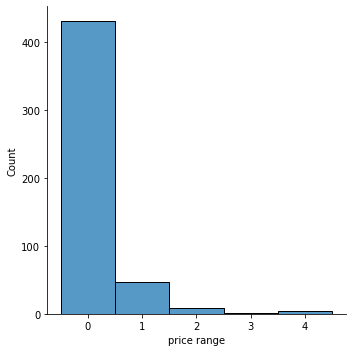

In [98]:
# TODO: snap ik niet goed haha
upper_bound = cleaned_listing_df["price range"].str.split(" - ").str[1]
upper_bound = upper_bound.str.split('€').str[1]
upper_bound = pd.to_numeric(upper_bound)

lower_bound = cleaned_listing_df["price range"].str.split(" - ").str[0]
lower_bound = lower_bound.str.split('€').str[1]
lower_bound = pd.to_numeric(lower_bound)

# TODO in opl staat - maar lijkt me nog steeds raar dus ik heb er + van gemaakt
# eens vragen aan begeleiders?
average = (upper_bound+lower_bound)/2

transformer = preprocessing.FunctionTransformer(pd.cut, kw_args={'bins': 5, 'labels': [0, 1, 2, 3, 4], 'retbins': True})
avg_quantfied = transformer.fit_transform(average)

#show the bin range
print(avg_quantfied)

#visualize the data
sn.displot(avg_quantfied[0])

cleaned_listing_df['price range average'] =  pd.to_numeric(avg_quantfied[0])

In [99]:
cleaned_listing_df.head()

,rank,restaurant name,general rating,number of reviews,tags,address,travelers choice,michelin,food rating,service rating,value rating,description,price range,cuisines,special diets,meals,restaurant features,id,price range average
787,7,Bistro Ruyterhof,4.5,13,$$ - $$$|French|Belgian|European,"Grote Baan 159, Waasmunster 9250 Belgium",False,False,5.0,5.0,5.0,NaN,€19 - €38,"French, Belgian, European, Healthy",NaN,"Lunch, Dinner","Reservations, Table Service, Seating, Gift Car...",21149871,0.0
2005,655,Restop,3.5,8,$$ - $$$|French|Belgian|European,Skaldenstraat 30 Aan de brug over de Kennedyla...,False,False,3.5,3.5,3.5,Large restaurant with meeting rooms & road fac...,€11 - €23,"French, Belgian, European",NaN,"Drinks, Breakfast, Lunch, Dinner","Takeout, Outdoor Seating, Seating, Parking Ava...",7917202,0.0
426,199,Souvenir,4.5,42,$$$$|Belgian|Seafood|European,"Brabantdam 134, Ghent 9000 Belgium",False,True,4.5,4.0,4.0,Souvenir represents contemporary gastronomy. B...,€35 - €95,"European, Belgian, Seafood, Contemporary",Vegetarian Friendly,"Lunch, Dinner","Reservations, Seating, Serves Alcohol, Accepts...",14948267,1.0
2314,757,Pizza Hut,2.5,101,$$ - $$$|Pizza|Vegetarian Friendly,"Korenmarkt 34, Ghent 9000 Belgium",False,False,3.0,3.0,3.5,NaN,No pricing available,Pizza,Vegetarian Friendly,"Lunch, Dinner","Takeout, Outdoor Seating, Seating, Highchairs ...",8025230,NaN
1295,4,Kafabel,4.0,14,$$ - $$$|Belgian|European,"Keiberg 2 Letterhoutem, Sint-Lievens-Houtem 95...",False,False,4.0,4.0,4.0,NaN,No pricing available,"Belgian, European",NaN,"Lunch, Dinner","Reservations, Seating, Table Service, Wheelcha...",12353374,NaN


Omdat we een verband zoeken tussen de prijs en de steden, gaan we ook een nieuwe kolom maken met de stad.

In [100]:
cleaned_listing_df['city'] = cleaned_listing_df['address'].str.split(" Belgium").str[0]
cleaned_listing_df['city'] = cleaned_listing_df['city'].str.split(",").str[-1]
cleaned_listing_df['city'] = cleaned_listing_df['city'].str.split(" ").str[1]

TODO: weet iemand of da makkelijker werkt als we tags, cuisines, special diets, meals, restaurant features omzetten naar arrays? dan doe ik da ook nog

=> ja

In [101]:
cleaned_listing_df['tags'] = cleaned_listing_df['tags'].str.split('|')
cleaned_listing_df['cuisines'] = cleaned_listing_df['cuisines'].str.split(',')
cleaned_listing_df['special diets'] = cleaned_listing_df['special diets'].str.split(',')
cleaned_listing_df['meals'] = cleaned_listing_df['meals'].str.split(',')
cleaned_listing_df['restaurant features'] = cleaned_listing_df['restaurant features'].str.split(',')

## Ontbrekende waarden

Wanneer er een rating (food, service, value, atmosphere) ontbreekt gaan we deze vervangen door de general rating. De general rating wordt berekend door de gemiddelde waarde te nemen van deze 4 waarden. Door de general rating te gebruiken verandert deze niet omdat het gemiddelde niet wijzigt.

In [102]:
# Check if average of 4 ratings equals general rating
#check_assumption = cleaned_listing_df[cleaned_listing_df["food rating"] != -1]
#check_assumption = cleaned_listing_df[cleaned_listing_df["service rating"] != -1]
#check_assumption = cleaned_listing_df[cleaned_listing_df["value rating"] != -1]
#check_assumption = cleaned_listing_df[cleaned_listing_df["atmosphere rating"] != -1]

#check_assumption["average"] = check_assumption["food rating"] + check_assumption["value rating"] +  check_assumption["atmosphere rating"] +  check_assumption["service rating"]
#check_assumption["average"] = round(check_assumption["average"].div(4),1)
#check_assumption.head()

#TODO: warning
#OPM: onze veronderstelling klopt niet (altijd) 
#cleaned_listing_df["sum"] = (cleaned_listing_df[cleaned_listing_df["food rating"] != -1] + cleaned_listing_df[cleaned_listing_df["service rating"] != -1] + cleaned_listing_df[cleaned_listing_df["value rating"] != -1] + cleaned_listing_df[cleaned_listing_df["atmosphere rating"] != -1])

## Data uitprinten

In deze sectie wordt er een histogram geplot van alle attributen. Op die manier kunnen uitschieters en 'skewed plots' gedecteerd worden. TODO: heeft dit zin want een rating wordt sws maar beperkt tussen 0 - 5? (dit werd wel gedaan in de theorieles)

array([[<AxesSubplot:title={'center':'rank'}>,
        <AxesSubplot:title={'center':'general rating'}>,
        <AxesSubplot:title={'center':'number of reviews'}>],
       [<AxesSubplot:title={'center':'food rating'}>,
        <AxesSubplot:title={'center':'service rating'}>,
        <AxesSubplot:title={'center':'value rating'}>],
       [<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price range average'}>,
        <AxesSubplot:>]], dtype=object)

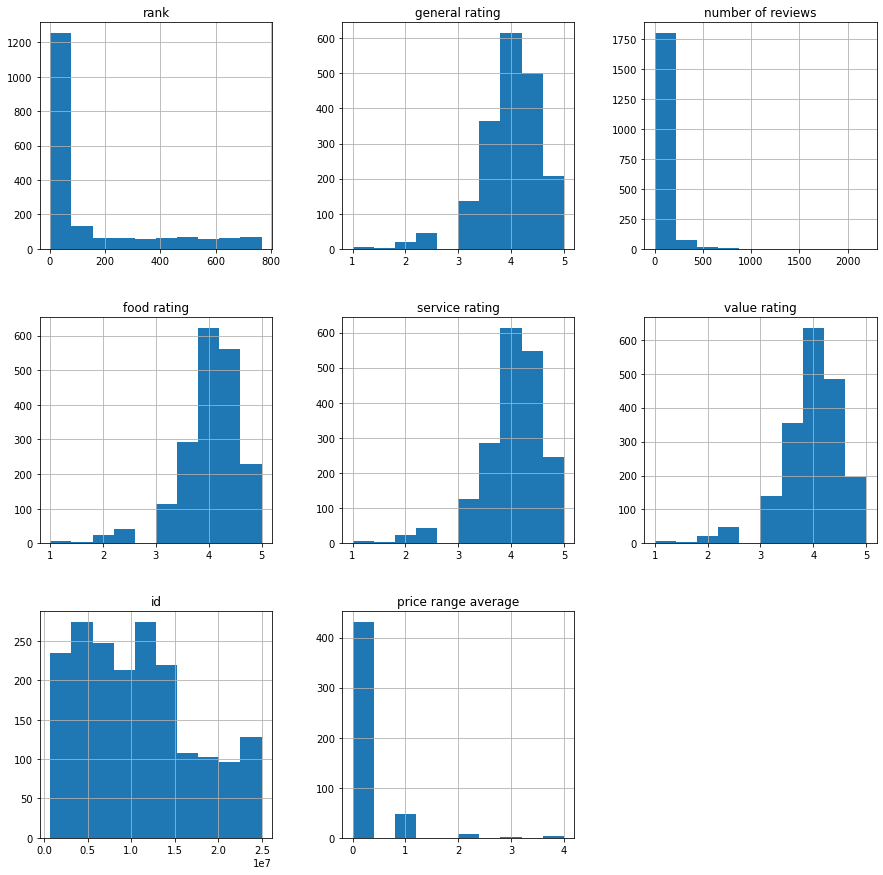

In [103]:
cleaned_listing_df.hist(figsize=(15,15))

                     general rating
general rating             1.000000
food rating                0.910037
value rating               0.899326
service rating             0.897356
id                         0.191521
michelin                   0.106712
travelers choice           0.094714
price range average        0.076557
number of reviews          0.003628
rank                      -0.164678


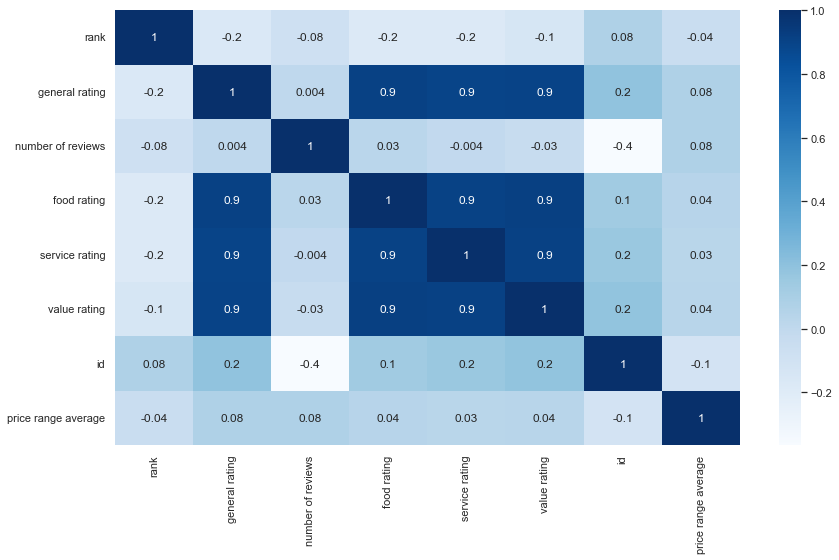

In [108]:
# Visualize the result for better interpretion 
# Hint: seaborn,  matplotlib.pyplot
import seaborn as sns
import matplotlib.pyplot as plt
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Try to get the correlation against general rating
print(cleaned_listing_df.corr()['general rating'][:].sort_values(ascending=False).to_frame())

# Show the correlation as heat map to see the difference
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = cleaned_listing_df.select_dtypes(include=numerics).corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')